In [3]:
import numpy as np
from functools import partial
import pandas as pd
#import matplotlib as mpl
#mpl.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
%matplotlib inline 

def get_heatRes(sig0, aH, E_keV):
    """return the heat resolution at energy E_keV.  sig0, E_keV assumed to be in units of keV."""
    
    # see eqn (5) in 2004 NIMA Edelweiss paper
    sigH = np.sqrt(sig0**2 + (aH*E_keV)**2)
    
    # multiply by 2.355 to get FWHM
    return sigH

def get_heatRes_func(FWHM0, FWHM122):
    """returns a resolution function given the FWHM values at 0 keV and 122 keV"""
    
    # convert from FWHM to sigma
    sig0 = FWHM0/2.355
    sig122 = FWHM122/2.355
    
    # calculate aH, which is unitless
    aH = np.sqrt((sig122**2 - sig0**2)/122**2)
    print (aH)
    
    # create function
    return partial(get_heatRes, sig0, aH)

def get_ionRes_func(FWHM_center, FWHM_guard, FWHM122):
    FWHM0 = np.sqrt(FWHM_center**2 + FWHM_guard**2)
    
    return get_heatRes_func(FWHM0, FWHM122)
    

In [8]:
def Q_avg(E_keV):
    return 0.16*np.power(E_keV,0.18)

def get_sig_gamma(sigI, sigH, V, E_keV):
    return ((1+V/3)/E_keV)*np.sqrt(sigI(E_keV)**2 + sigH(E_keV)**2)

def get_sig_gamma_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V):
    # get the ionization resolution function
    sigI = get_ionRes_func(FWHM_center, FWHM_guard, FWHM122_ion)
    
    # get the heat resolution function
    sigH = get_heatRes_func(FWHM0_heat, FWHM122_heat)
    
    return partial(get_sig_gamma, sigI, sigH, V)
    

In [4]:
get_heatRes_func(0.843*2.355, 3.1)
heatRes_GGAl10 = get_heatRes_func(0.4, 3.5)
heatRes_GGAl10_guard = get_heatRes_func(0.655, 4.0)

0.00828689566954
0.0121021465669
0.0137343199886


In [5]:
heatRes_GGAl10(50)

0.62849373117045848

In [6]:
heatRes_data = pd.read_csv("resolution_GeAl10_dataPoints_correctedEnergies.txt", skiprows=1)
print (heatRes_data.head(10))

   Energy    FWHM   error
0  122.10  3.9992  0.4938
1   46.52  1.8558  0.2918
2   10.37  0.6831  0.0757
3    0.00  0.6551  0.0814


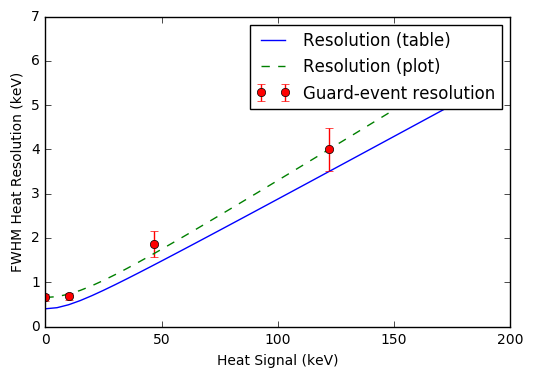

In [7]:
# plot the heat resolution, reproduce fig 2d from 2004 NIMA Edelweiss paper
E_vec = np.arange(0,200,5)
table, = plt.plot(E_vec, 2.355*heatRes_GGAl10(E_vec), label='Resolution (table)')
plot, = plt.plot(E_vec, 2.355*heatRes_GGAl10_guard(E_vec), linestyle='--', label='Resolution (plot)')
data = plt.errorbar(heatRes_data.Energy, heatRes_data.FWHM,yerr=heatRes_data.error,fmt='o', label='Guard-event resolution')
plt.xlabel("Heat Signal (keV)")
plt.ylabel("FWHM Heat Resolution (keV)")
plt.legend(handles=[table, plot, data])

In [12]:
band_data = pd.read_csv("edelweiss_bands_GGA1.csv")
print (band_data.head(10))

       x   Curve1   curve2   curve3   curve4
0  1.667 -6.44581 -0.08957  1.49300 -0.64478
1  1.802 -6.06069 -0.08789  1.44296 -0.62392
2  1.804 -6.05415 -0.08786  1.46798 -0.62356
3  1.938 -5.68168 -0.08613  1.41795 -0.60321
4  2.075 -5.31531 -0.08430  1.39293 -0.58303
5  2.212 -4.96139 -0.08240  1.36791 -0.56335
6  2.883 -3.39678 -0.07177  1.11174 -0.47381
7  3.158 -2.83384 -0.06656  1.10052 -0.44031
8  3.295 -2.57110 -0.06372  1.06171 -0.42438
9  4.518 -0.66571 -0.01776  0.75550 -0.30031


In [13]:
# get_sig_gamma_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V)
sig_gamma_GGA1 = get_sig_gamma_func(1.2, 1.3, 2.8, 1.3, 3.5, 4)

0.00755369963253
0.0113104847094


(0, 1.5)

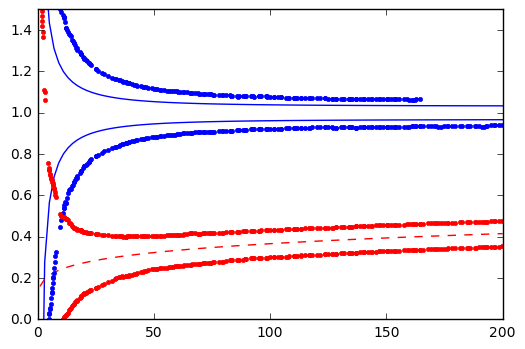

In [16]:
E_keV_arr = np.linspace(1,200,100)

# plot the ionization bands
plt.plot(E_keV_arr, 1+sig_gamma_GGA1(E_keV_arr), 'b-')
plt.plot(E_keV_arr, 1-sig_gamma_GGA1(E_keV_arr), 'b-')

# plot the central nuclear recoil line
plt.plot(E_keV_arr, Q_avg(E_keV_arr),'r--')

# plot the data-theifed bands
plt.plot(band_data.x[band_data.x>7.82], band_data.Curve1[band_data.x>7.82], 'b.')
plt.plot(band_data.x, band_data.curve2, 'b.')
plt.plot(band_data.x, band_data.curve3, 'r.')
plt.plot(band_data.x, band_data.curve4, 'r.')
plt.ylim(0,1.5)